In [19]:
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
from tensorflow.python.data.ops.dataset_ops import PrefetchDataset

### 1. Найти данные для классификации. Данные в группе повторяться не должны! Предобработать данные, если это необходимо.

In [20]:
# dataset, metadata = tfds.load('eurosat', as_supervised=True, with_info=True)
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
dataset: PrefetchDataset = dataset['train']
dataset = dataset.take(5000) # svm работает оч неторопливо (время квадратично от размера)

In [21]:
import tensorflow as tf
def convert_img_to_grayscale(image) -> list:
    return tfds.as_numpy(tf.image.rgb_to_grayscale(image)).ravel().tolist()

# class_names = [
#     'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
#     'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
class_names = [
    'Футболка / топ', "Шорты", "Свитер", "Платье",
    "Плащ", "Сандали", "Рубашка", "Кроссовок", "Сумка",
    "Ботинок"]
# data_reshaped = pd.DataFrame([convert_img_to_grayscale(image) for image, label in dataset])
# target_names = pd.Series([class_names[label] for image, label in tfds.as_numpy(dataset)])

In [22]:
data_reshaped = pd.DataFrame([image.ravel().tolist() for image, label in tfds.as_numpy(dataset)])
target_names = pd.Series([class_names[label] for image, label in tfds.as_numpy(dataset)])

In [23]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
data_reshaped = pd.DataFrame(scaler.fit_transform(data_reshaped), columns=data_reshaped.columns)
data_reshaped.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07563,...,0.000000,0.000000,0.000000,0.432653,0.184314,0.270588,0.09465,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.564516,0.618474,0.023529,0.000000,0.192157,0.145098,0.00000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.036290,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0


### 2. Изобразить гистограмму, которая показывает баланс классов. Сделать выводы.

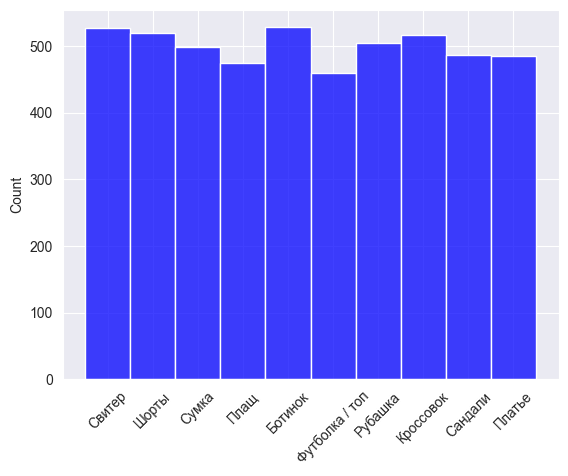

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.xticks(rotation=45)
sns.histplot(target_names, color='b');

### 3. Разбить выборку на тренировочную и тестовую. Тренировочная для обучения модели, тестовая для проверки ее качества.

In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_reshaped, target_names, train_size=0.8, shuffle=True, random_state=271)

In [26]:
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

### 4. Применить алгоритмы классификации: логистическая регрессия, SVM, KNN.
### Построить матрицу ошибок по результатам работы моделей (использовать confusion_matrix из sklearn.metrics).
#### Логистическая регрессия

In [27]:
regression_model = LogisticRegression(max_iter=100, random_state=271, n_jobs=-1)
regression_time = datetime.now()
regression_model.fit(x_train, y_train)
regression_time = datetime.now() - regression_time
regression_predict = regression_model.predict(x_test)

#### SVM (метод опорных векторов)

In [28]:
svc_model = LinearSVC(max_iter=100, random_state=271)
svc_time = datetime.now()
svc_model.fit(x_train, y_train)
svc_time = datetime.now() - svc_time
svc_predict = svc_model.predict(x_test)

C:\Users\dima2\venvs\venv_bd\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### KNN - k Nearest Neighbor

In [29]:
knn_model = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
knn_time = datetime.now()
knn_model.fit(x_train, y_train)
knn_time = datetime.now() - knn_time
knn_predict = knn_model.predict(x_test)

In [30]:
from sklearn.metrics import confusion_matrix
def show_conf_matrix(test, predict, ax_, cbar=False):
    sns.heatmap(confusion_matrix(test, predict), annot=True, fmt='', ax=ax_, cbar=cbar)

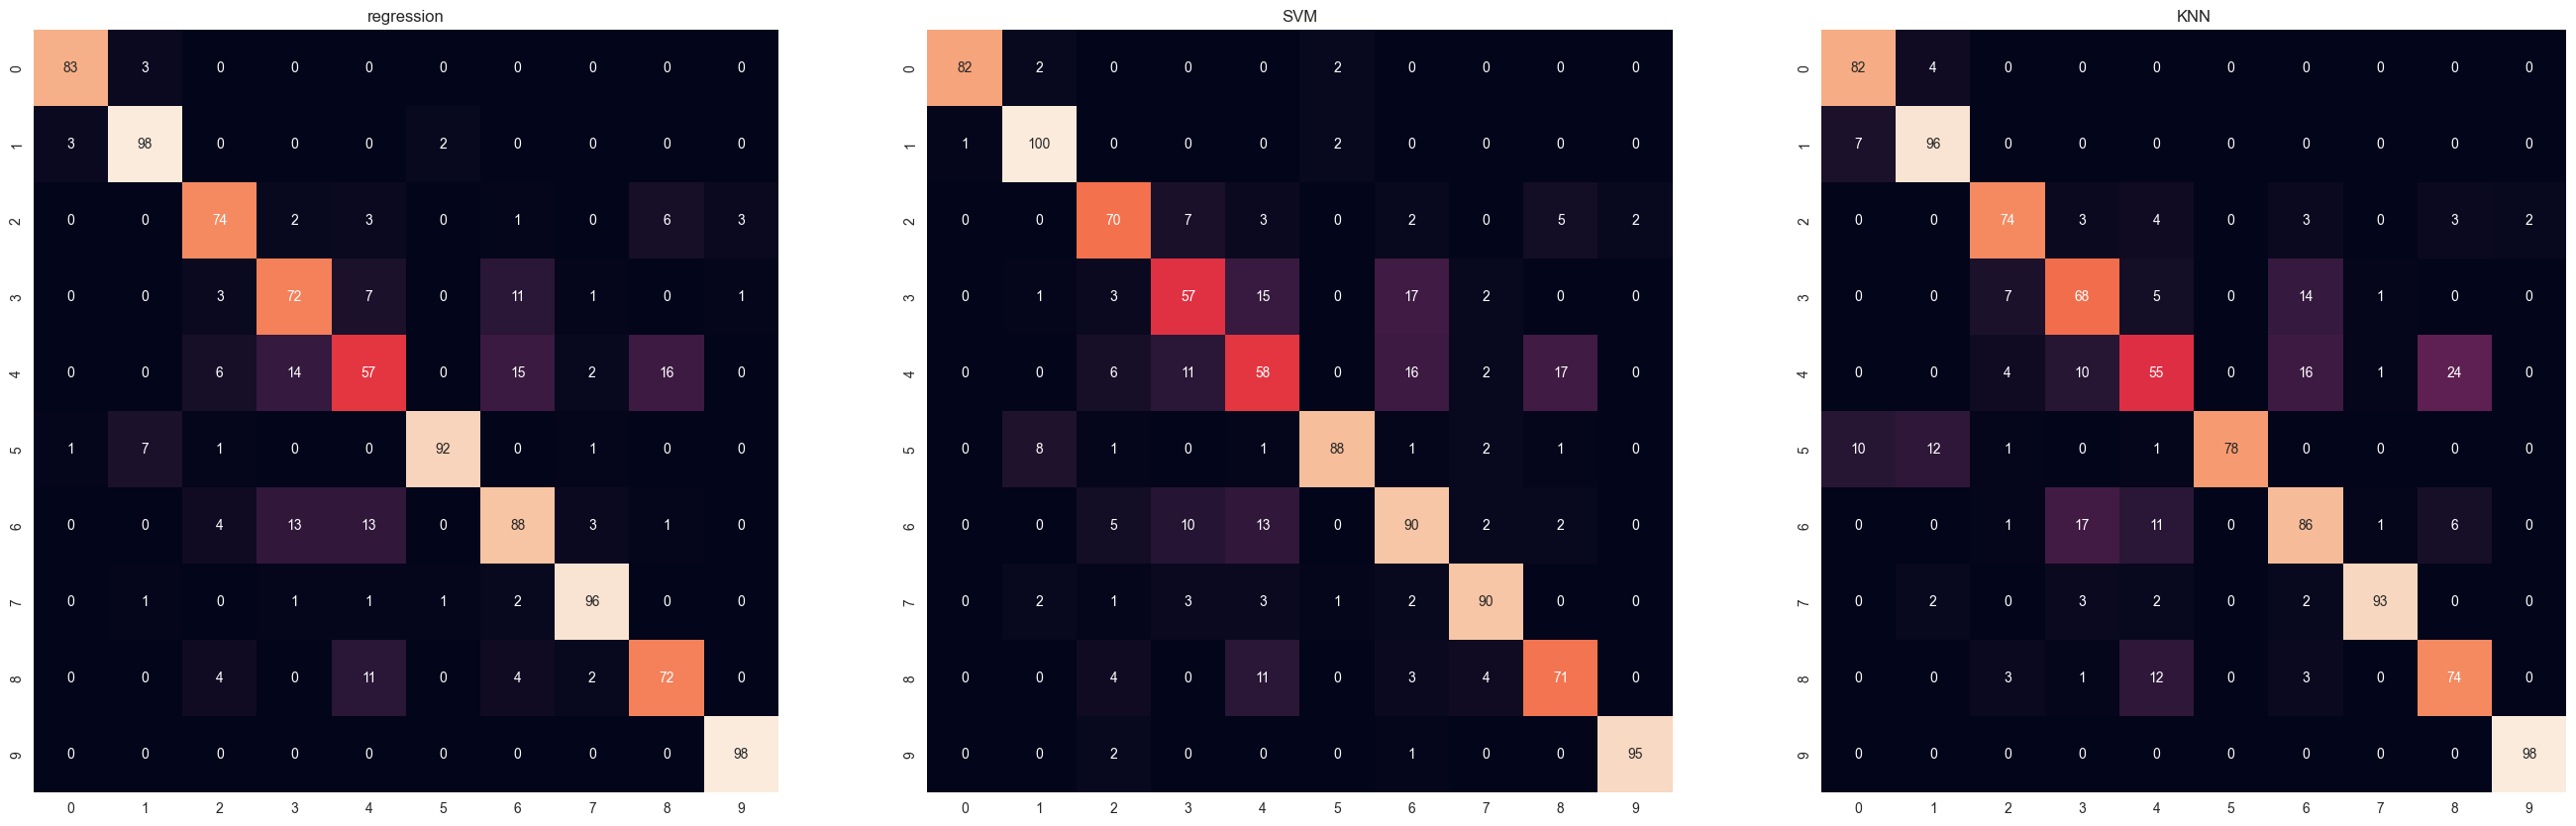

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(33, 10))
ax1.set_title('regression')
ax2.set_title('SVM')
ax3.set_title('KNN')
show_conf_matrix(y_test, regression_predict, ax1)
show_conf_matrix(y_test, svc_predict, ax2)
show_conf_matrix(y_test, knn_predict, ax3)

### 5. Сравнить результаты классификации, используя accuracy, precision, recall и f1-меру
### (можно использовать classification_report из sklearn.metrics).
### Также сравнить время работы алгоритмов. Сделать выводы.

In [32]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.metrics import classification_report
def show_stats(model_name: str, model_predict, model_time):
    print(f'Модель {model_name}:')
    print('время обучения модели:', model_time)
    print('accuracy_score:', accuracy_score(y_test, model_predict))
    print('precision_score:', precision_score(y_test, model_predict, average='weighted'))
    print('recall_score:', recall_score(y_test, model_predict, average='weighted'))
    print('f1_score:', f1_score(y_test, model_predict, average='weighted'))
    print()

In [33]:
show_stats('regression', regression_predict, regression_time)
show_stats('SVM', svc_predict, svc_time)
show_stats('KNN', knn_predict, knn_time)

Модель regression:
время обучения модели: 0:00:01.716701
accuracy_score: 0.83
precision_score: 0.826853871787095
recall_score: 0.83
f1_score: 0.8275548729135259

Модель SVM:
время обучения модели: 0:00:00.906557
accuracy_score: 0.801
precision_score: 0.8011705126165307
recall_score: 0.801
f1_score: 0.8003506935059416

Модель KNN:
время обучения модели: 0:00:00.014930
accuracy_score: 0.804
precision_score: 0.8074856589060718
recall_score: 0.804
f1_score: 0.8023909227511948



In [34]:
print(classification_report(y_test, regression_predict))

                precision    recall  f1-score   support

       Ботинок       0.95      0.97      0.96        86
     Кроссовок       0.90      0.95      0.92       103
        Платье       0.80      0.83      0.82        89
          Плащ       0.71      0.76      0.73        95
       Рубашка       0.62      0.52      0.56       110
       Сандали       0.97      0.90      0.93       102
        Свитер       0.73      0.72      0.72       122
         Сумка       0.91      0.94      0.93       102
Футболка / топ       0.76      0.77      0.77        93
         Шорты       0.96      1.00      0.98        98

      accuracy                           0.83      1000
     macro avg       0.83      0.84      0.83      1000
  weighted avg       0.83      0.83      0.83      1000



In [35]:
print(classification_report(y_test, svc_predict))

                precision    recall  f1-score   support

       Ботинок       0.99      0.95      0.97        86
     Кроссовок       0.88      0.97      0.93       103
        Платье       0.76      0.79      0.77        89
          Плащ       0.65      0.60      0.62        95
       Рубашка       0.56      0.53      0.54       110
       Сандали       0.95      0.86      0.90       102
        Свитер       0.68      0.74      0.71       122
         Сумка       0.88      0.88      0.88       102
Футболка / топ       0.74      0.76      0.75        93
         Шорты       0.98      0.97      0.97        98

      accuracy                           0.80      1000
     macro avg       0.81      0.81      0.81      1000
  weighted avg       0.80      0.80      0.80      1000



In [36]:
print(classification_report(y_test, knn_predict))

                precision    recall  f1-score   support

       Ботинок       0.83      0.95      0.89        86
     Кроссовок       0.84      0.93      0.88       103
        Платье       0.82      0.83      0.83        89
          Плащ       0.67      0.72      0.69        95
       Рубашка       0.61      0.50      0.55       110
       Сандали       1.00      0.76      0.87       102
        Свитер       0.69      0.70      0.70       122
         Сумка       0.97      0.91      0.94       102
Футболка / топ       0.69      0.80      0.74        93
         Шорты       0.98      1.00      0.99        98

      accuracy                           0.80      1000
     macro avg       0.81      0.81      0.81      1000
  weighted avg       0.81      0.80      0.80      1000

